# Implimeting ML model into trade strategy

In [29]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   -- ------------------------------------- 7.9/150.0 MB 40.7 MB/s eta 0:00:04
   ----- ---------------------------------- 19.7/150.0 MB 49.6 MB/s eta 0:00:03
   -------- ------------------------------- 30.9/150.0 MB 53.1 MB/s eta 0:00:03
   ----------- ---------------------------- 43.0/150.0 MB 53.6 MB/s eta 0:00:02
   ------------- -------------------------- 52.2/150.0 MB 54.5 MB/s eta 0:00:02
   ----------------- ---------------------- 65.5/150.0 MB 54.3 MB/s eta 0:00:02
   -------------------- ------------------- 76.8/150.0 MB 55.0 MB/s eta 0:00:02
   ----------------------- ---------------- 89.9/150.0 MB 55.7 MB/s eta 0:00:02
   -------------------------- ------------ 100.7/150.0 MB 55.9 MB/s eta 0:00:01
   ----------------------------- --------- 114.3/150.0 MB 56.6 MB/s eta 0:00:01
   -------------------------------- ------ 126.1/150.0 MB 56.7 MB/s eta 0:00:01
   ----------------------------------- --- 138.4/1

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from ta import momentum, volatility, trend
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils import resample
from xgboost import XGBClassifier

In [33]:
import asyncio
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.data.enums import DataFeed
from alpaca.data.timeframe import TimeFrame
import matplotlib.pyplot as plt
from datetime import datetime
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest

# Load environment variables
load_dotenv()  # Load .env file

API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")

# Initialize TradingClient
Trading_Client = TradingClient(API_KEY, API_SECRET, paper=True)  # paper=True for paper trading
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)
SYMBOL = "MSFT"

Fetching historical data for MSFT...
Generating features...
Labeling data based on future returns...

Label distribution after labeling:
label
0.0    102680
1.0     50094
Name: count, dtype: int64
Training RandomForest with class_weight='balanced'...

=== Classification Report (Threshold = 0.5) ===
              precision    recall  f1-score   support

         0.0       0.72      0.59      0.65     30954
         1.0       0.38      0.53      0.44     14879

    accuracy                           0.57     45833
   macro avg       0.55      0.56      0.54     45833
weighted avg       0.61      0.57      0.58     45833


Confusion Matrix:
[[18191 12763]
 [ 7057  7822]]


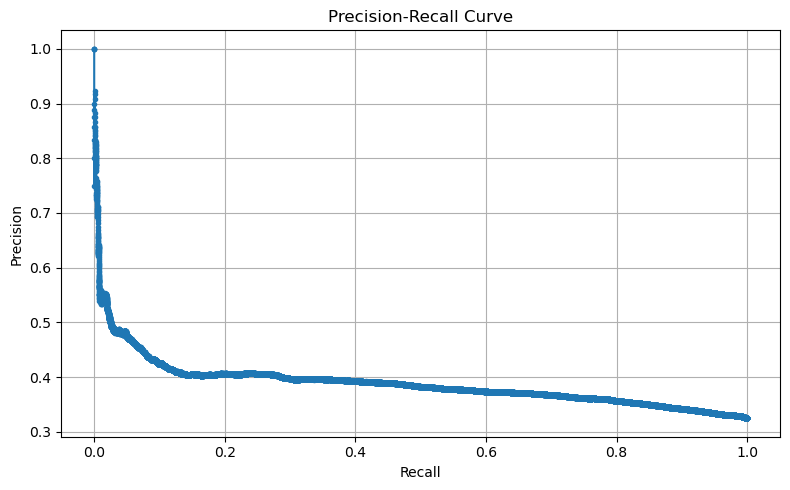


=== Feature Importances ===
vol_rolling: 0.1627
volatility: 0.1440
atr_ratio: 0.1171
atr: 0.0980
sma_slope: 0.0784
rsi: 0.0638
volume_spike: 0.0634
macd_diff: 0.0541
macd_diff_lag1: 0.0398
rsi_lag2: 0.0352
rsi_lag1: 0.0340
rsi_lag3: 0.0328
macd_diff_lag3: 0.0285
macd_diff_lag2: 0.0284
trend_num: 0.0197

Saved predictions to ml_predictions.csv


In [37]:
LOOKAHEAD_BARS = 30
RETURN_THRESHOLD = 0.001
CUSTOM_THRESHOLD = 0.5  # adjust between 0.5 and 0.95

# === Step 1: Fetch Historical Data ===
print(f"Fetching historical data for {SYMBOL}...")
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)
request = StockBarsRequest(
    symbol_or_symbols=[SYMBOL],
    timeframe=TimeFrame.Minute,
    start=datetime(2024, 1, 1),
    end=datetime(2024, 12, 30),
    adjustment='all'
)
bars = data_client.get_stock_bars(request).df

# === Step 2: Clean and Prepare DataFrame ===
if isinstance(bars.index, pd.MultiIndex):
    df = bars.xs(SYMBOL, level='symbol').reset_index()
else:
    df = bars.reset_index()

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

# === Step 3: Feature Engineering ===
print("Generating features...")
df['rsi'] = momentum.RSIIndicator(df['close'], window=14).rsi()
df['atr'] = volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
df['macd_diff'] = trend.MACD(df['close']).macd_diff()
df['vol_rolling'] = df['volume'].rolling(30).mean()
df['atr_ratio'] = df['atr'] / df['close']

df['daily_close'] = df.groupby('date')['close'].transform('last')
df['sma_trend'] = df['daily_close'].rolling(20).mean()
df['daily_trend'] = np.where(df['daily_close'] > df['sma_trend'], 'up', 'down')
df['trend_num'] = df['daily_trend'].map({'up': 1, 'down': -1})

# Advanced features
df['returns'] = df['close'].pct_change()
df['volatility'] = df['returns'].rolling(20).std()
df['volume_spike'] = df['volume'] / df['volume'].rolling(20).mean()
df['sma_slope'] = df['sma_trend'].diff()

for lag in range(1, 4):
    df[f'rsi_lag{lag}'] = df['rsi'].shift(lag)
    df[f'macd_diff_lag{lag}'] = df['macd_diff'].shift(lag)

# === Step 4: Label Generation Based on Future Returns ===
def generate_labels_by_future_return(df, lookahead=30, threshold=0.01):
    labels = []
    for i in range(len(df) - lookahead):
        future_return = (df['close'].iloc[i + lookahead] - df['close'].iloc[i]) / df['close'].iloc[i]
        labels.append(1 if future_return >= threshold else 0)
    labels += [np.nan] * lookahead
    return pd.Series(labels, index=df.index)

print("Labeling data based on future returns...")
df['label'] = generate_labels_by_future_return(df, lookahead=LOOKAHEAD_BARS, threshold=RETURN_THRESHOLD)

# === Step 5: Prepare Training Data ===
features = [
    'rsi', 'macd_diff', 'vol_rolling', 'atr', 'atr_ratio', 'trend_num',
    'volatility', 'volume_spike', 'sma_slope',
    'rsi_lag1', 'rsi_lag2', 'rsi_lag3',
    'macd_diff_lag1', 'macd_diff_lag2', 'macd_diff_lag3'
]

df = df.dropna(subset=features + ['label'])
X = df[features]
y = df['label']

print("\nLabel distribution after labeling:")
print(y.value_counts())

# === Step 6: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# === Step 7: Train Model with Class Weighting ===
print(f"Training RandomForest with class_weight='balanced'...")
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# === Step 8: Prediction with Thresholding ===
probs = model.predict_proba(X_test)[:, 1]
y_pred_thresh = (probs > CUSTOM_THRESHOLD).astype(int)

# === Step 9: Evaluation ===
print(f"\n=== Classification Report (Threshold = {CUSTOM_THRESHOLD}) ===")
print(classification_report(y_test, y_pred_thresh, zero_division=0))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_thresh))

# === Step 10: Precision-Recall Curve ===
precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.tight_layout()
plt.show()

# === Step 11: Feature Importance ===
print("\n=== Feature Importances ===")
importances = model.feature_importances_
for feat, imp in sorted(zip(features, importances), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")

# === Step 12: Save Prediction Output ===
df.loc[X_test.index, 'predicted_label'] = y_pred_thresh
df.loc[X_test.index, 'predicted_prob'] = probs
df[['timestamp', 'close', 'label', 'predicted_label', 'predicted_prob']].to_csv("ml_predictions.csv", index=False)

print("\nSaved predictions to ml_predictions.csv")